# CSE 6240 Web Search and Text Mining 
# Homework 5: Graph Convolution Network

This homework asks you to build Multilayer perceptron(MLP) and Graph convolution network(GCN), and compare the performance on two graph related tasks. 

- The first is semi-supervised node classification where given a graph with some nodes labelled, you need to find the labels of the unlabelled nodes

- The second is self-supervised link prediction, where given a graph, we learn to predict whether there is a link between two nodes or not

# GPU Setup [0.1 points for reading and understanding]

First, let us setup the GPUs on your system and the required libraries. We follow the following steps. 
1. If using Google Colab (highly recommended), enable GPU runtime. Go to Runtime -> Change Runtime type -> Select GPU as the hardware accelerator and hit Save. 
2. Then, we will install CUDA11.6 as it is not available on Colab as default. We want to install 11.6 because torch is not available for CUDA 11.8 (which is the default version). For this, we will follow the steps as provided here: https://developer.nvidia.com/cuda-11-6-0-download-archive. The following lines of code are for an Ubuntu 20.04 x86_64 machine. This is also the configuration that you'd get on Google Colab. You may want to change them to match your system configuration (don't change if on Colab). 
3. Then, we will set the environment variables (PATH and LD_LIBRARY_PATH) to take the newly installed CUDA version instead of the old versions that may already be installed. 
4. Finally, we install the torch and torch_geometric libraries. 

These steps should prove useful for you whenever you may want to set up GPU compatible with the libraries (for your future projects, for example) so do make a note of these instructions (even though you don't have to write any code). 

In [1]:
# Don't change if on Google Colab
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-ubuntu2004.pin
!mv cuda-ubuntu2004.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget -nc https://developer.download.nvidia.com/compute/cuda/11.6.0/local_installers/cuda-repo-ubuntu2004-11-6-local_11.6.0-510.39.01-1_amd64.deb
!dpkg -i cuda-repo-ubuntu2004-11-6-local_11.6.0-510.39.01-1_amd64.deb
!apt-key add /var/cuda-repo-ubuntu2004-11-6-local/7fa2af80.pub
!apt-get update
!apt-get -y install cuda-11-6


--2023-03-25 22:49:51--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-ubuntu2004.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu2004.pin’

cuda-ubuntu2004.pin 100%[===================>]     190  --.-KB/s    in 0s      

2023-03-25 22:49:51 (4.16 MB/s) - ‘cuda-ubuntu2004.pin’ saved [190/190]

--2023-03-25 22:49:51--  https://developer.download.nvidia.com/compute/cuda/11.6.0/local_installers/cuda-repo-ubuntu2004-11-6-local_11.6.0-510.39.01-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 O

In [2]:
# Don't change
import os
os.environ['PATH'] = "/usr/local/cuda-11.6/bin:" + os.environ['PATH']
os.environ['LD_LIBRARY_PATH'] = "/usr/local/cuda-11.6/lib64:" + os.environ['LD_LIBRARY_PATH']


In [3]:
# Check if the version is 11.6
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0


In [4]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


In [5]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-1.13.1+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.4/868.4 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 KB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=19b3027aa7c4162ffb1eb94f840bff7d7af76d2ee47faabf1c5d18a8a0001346
  Stored in directory: /root/.cache/pip/wheels/cd/7d

Once the GPU is set up and the required libraries are installed, restart runtime and just run the code from here (i.e., no need to set up the system again). 

In [6]:
import torch
import torch_geometric

In [7]:
# Free 0.1 points for understanding the above steps and successfully enabling CUDA and installing libraries. If you set it up on your local machine 
# (for which you would need to change the above steps to match your local configuration), kudos to you!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (torch.cuda.is_available())

True


# Data loading

In [8]:
from torch_geometric.datasets import Planetoid

# Checkout the documentation https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid
# for more details about the dataset

name = 'Citeseer'
dataset= Planetoid('./', name)
data = dataset[0].to(device)

Processing...
Done!


Check the different variables of the Planetoid data object and understand their meanings from the documentation (https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid). You would need them. 

In [9]:
[x for x in dir(dataset) if x.startswith('num')]

['num_classes', 'num_edge_features', 'num_features', 'num_node_features']

In [10]:
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

Suppose the graph is $\mathbf{G} = (\mathbf{X}, (\mathbf{V}, \mathbf{E}))$, where $\mathbf{X}$ denote the note attribute matrix of size $N \times F$, $\mathbf{V}$ denotes the set of nodes ($N = |\mathbf{V}|$), and $\mathbf{E}$ denotes the set of edges. Then, we store this graph in the following data structure:

- `data.x`: Node feature matrix $\mathbf{X}$
- `data.edge_index`: Set of edges $\mathbf{E}$ sorted in an increasing order of the first node id (and second node id if same first node id).
- `data.train_mask`: Training set of node ids for node classification
- `data.val_mask`: Validation set of node ids for node classification
- `data.test_mask`: Validation set of node ids for node classification

For more details, refer the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid). 

# Section 1: Node classification task [3.5 points]


In this section, we will perform node classfication on the Citeseer dataset. As an initial step, we need to implement a two-layer MLP model. After that, we will implement and use a two-layer GCN model. Finally, we will compare the performance between the MLP and GCN models.

## Section 1.1: General Model [1.5 points]

#### Model Definition [0.2 points]

First let us define a model that tries to memorize the class probabilities directly for each node without using the features or the graph structure.

In [11]:
import torch
import torch.nn.functional as F

class NCModel (torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.logits = torch.nn.Parameter(torch.rand(dataset[0].num_nodes, dataset.num_classes))
        self.num_classes = dataset.num_classes
    
    def forward (self, data):
        # returns log probabilities for each class in num_classes
        # Default is a random distribution
        return F.log_softmax(self.logits, dim=1)

    def predict (self, data):
        pred = None
        # Step 1: Run forward pass on the entire data to obtain the logits for each class. 
        logits = self.forward(data)

        # Step 2: Obtain the predicted class as the one with the highest logit value. Store the predicted class in the variable pred.
        ### write your code below [0.2 points] ##
        pred = []
        for row in logits:
          m = max(row)
          for i in range(len(row)):
            if row[i] == m:
              pred.append(i)
        #########################################
        return pred

In [12]:
mem_model = NCModel (dataset).to(device)

### General Training [1.3 points]

**Setup** [0.2 points]

In [13]:
criterion = None

# Initialize loss criterion as the negative log likelihood function
### write your code below [0.1 points] ##
criterion = torch.nn.NLLLoss()
#########################################

def optimizer_fn (model, lr, wd):
    optimizer = None
    # Return a SGD optimizer over the parameters of the model with learning rate = lr and weight_decay=wd for the gradient descent updates.
    ### write your code below [0.1 points] ##
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    #########################################
    return optimizer

**Backpropagating the loss criterion** [0.5 points]

In [14]:
# Gradient Descent training algorithm. We will use this function for MLP and GCN too.
def train (model, data, criterion, optimizer):
    model.train()
    train_loss = None
    # Step 1: Run forward pass on the entire graph dataset. Note that this is a semi-supervised setting. 
    # Step 2: Extract the class probabilities of only the training nodes (you can use data.train_mask to obtain them). 
    # Step 3: Compute the loss between predicted probabilities and the actual labels of training nodes and store it in train_loss
    # Step 4: Compute the gradients of the training loss with respect to each parameter using the backward() call.
    # Step 5: Update the model parameters using the optimizer step() call.
    # Make sure to return a detached cpu tensor
    ### write your code below [0.4 points] ##

    # step1
    f_pass = model.forward(data)
    # step2
    f_pass_training = f_pass[data.train_mask]
    # step3
    train_loss = criterion(f_pass_training, data.y[data.train_mask])
    # step4
    grad = train_loss.backward()
    # step5
    optimizer.step()
    
    #########################################
    return train_loss.detach().cpu()

**Validation** [0.2 points]

In [15]:
# Validate the model on a held-out validataion dataset. We will reuse this function for GCN too.
def validate (model, data, criterion):
    model.eval()
    val_loss = None
    with torch.no_grad():
        # Step 1: Run forward pass on the dataset. 
        # Step 2: Extract the class probabilities of only the validation nodes (you can use data.val_mask to obtain them). 
        # Step 3: Compute the loss between predicted probabilities and the actual labels of validation nodes and store it in val_loss
        # Make sure to return a CPU tensor.
        ### write your code below [0.2 points] ##

        # step1
        f_pass = model.forward(data)
        # step2
        f_pass_val = f_pass[data.val_mask]
        # step3

        val_loss = criterion(f_pass_val, data.y[data.val_mask])
        # print(type(val_loss))


        #########################################
    return val_loss.cpu()

**Training loop**

In [16]:
# Let us train this model.
torch.manual_seed(42)

# Hyperparameters of the model. DO NOT CHANGE.
num_epochs = 200 # Number of epochs
lr = 0.01 # learning rate, also called step size sometimes
wd = 1e-4 # Weight decay, regularization parameter (ensures that we don't overfit to the training data)

optimizer = optimizer_fn (mem_model, lr, wd)

training_loss = []
validation_loss = []

for epoch in range(1, num_epochs+1):
    train_loss = train (mem_model, data, criterion, optimizer)
    val_loss = validate (mem_model, data, criterion)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    # Print loss values every 10 epochs
    if epoch%10 == 0:
      print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')

Epoch: 010, Training Loss: 1.7985 Validation Loss: 1.8303
Epoch: 020, Training Loss: 1.7884 Validation Loss: 1.8303
Epoch: 030, Training Loss: 1.7714 Validation Loss: 1.8303
Epoch: 040, Training Loss: 1.7477 Validation Loss: 1.8303
Epoch: 050, Training Loss: 1.7173 Validation Loss: 1.8303
Epoch: 060, Training Loss: 1.6804 Validation Loss: 1.8303
Epoch: 070, Training Loss: 1.6373 Validation Loss: 1.8303
Epoch: 080, Training Loss: 1.5882 Validation Loss: 1.8303
Epoch: 090, Training Loss: 1.5335 Validation Loss: 1.8303
Epoch: 100, Training Loss: 1.4736 Validation Loss: 1.8303
Epoch: 110, Training Loss: 1.4089 Validation Loss: 1.8303
Epoch: 120, Training Loss: 1.3400 Validation Loss: 1.8303
Epoch: 130, Training Loss: 1.2674 Validation Loss: 1.8303
Epoch: 140, Training Loss: 1.1919 Validation Loss: 1.8303
Epoch: 150, Training Loss: 1.1140 Validation Loss: 1.8303
Epoch: 160, Training Loss: 1.0347 Validation Loss: 1.8303
Epoch: 170, Training Loss: 0.9547 Validation Loss: 1.8303
Epoch: 180, Tr

**Plotting the loss curves**

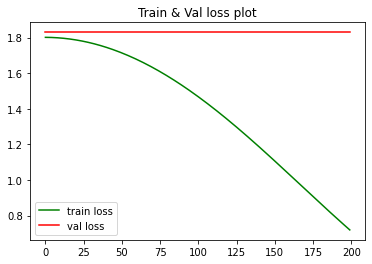

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(training_loss)), training_loss, color='green', label='train loss')
plt.plot(range(len(validation_loss)), validation_loss, color='red', label='val loss')
plt.legend()
plt.title("Train & Val loss plot")
plt.show()

**Evaluation** [0.4 points]
1. For this task, we will be using the standard accuracy metric which captures **`total_correct_predictions / total_predictions`** 
2. Accuracy should be calculated using the **test** nodes in dataset. Compute predictions for each node, and use the **predictions along with ground truth (y)** to get the accuracy value

Other metrics can be used, such as F1 and AUC, but we will restrict ourselves to accuracy as part of this homework. We will reuse the evaluate accuracy function below as well. 

In [18]:
# Let us evaluate the performance of the model on the node classification task
def evaluate_accuracy(model, data, eval_mask):
      acc = None
      # Step 1: Call the predict() function of model to get the predicted labels of the model.
      # Step 2: Extract the predicted labels of the `eval_mask` nodes (note that eval_mask could be one of the train_mask, val_mask, test_mask). 
      # Step 3: Extract the ground truth labels of the `eval_mask` nodes. 
      # Step 4: Use predicted class and ground truth class of `eval_mask` nodes to compute accuracy
      # To calculate accuracy use the following formula ""Accuracy = (number of correct predictions in the test set / size of test set)""
      # Write your code below [0.4 points]

      #########################################
      # step1
      all_preds = torch.tensor(model.predict(data)).to(device)
      # step2
      subset_preds = all_preds[eval_mask]
      # step3
      ground_truth_labels = data.y[eval_mask]
      # step4
      correct = 0
      for i in range(subset_preds.shape[0]):
        if subset_preds[i] == ground_truth_labels[i]:
          correct += 1
      
      acc = correct/subset_preds.shape[0]

      return acc

In [19]:
# Let us evaluate our model using accuracy of its predictions. 
test_acc = None
mem_model.eval()
with torch.no_grad():
    train_acc = evaluate_accuracy(mem_model, data, data.train_mask)
    val_acc = evaluate_accuracy(mem_model, data, data.val_mask)
    test_acc = evaluate_accuracy(mem_model, data, data.test_mask)

print(f'Accuracy: Train {train_acc:.4f}, Val {val_acc:.4f}, Test {test_acc:.4f}')
print(f"Sanity check for the test: {abs(test_acc - 1/6) <= 5e-2}")

Accuracy: Train 1.0000, Val 0.1440, Test 0.1790
Sanity check for the test: True


So, it's a useless model as it completely overfits on the data with no generalization as we learn a separate probability distribution for each node with no way of generalizing knowledge from training nodes. The model thus predicts randomly (there are 6 classes and thus, the accuracy for random predictions would be 1/6). 

## Section 1.2: MLP for node classification [0.9 points]

Let us now use the input data a little more carefully. In particular, let us make use of the input node attributes to learn the node labels using a two layer perceptron.

**MLP Model Definition** [0.9 points]

Implement a two layer MLP with hidden dimension size as 16 and train the model on the dataset. We want to use ReLU activation and dropout with p = 0.2

In [20]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP (NCModel):
    def __init__(self, dataset, hidden_channels=32, dropout_probability=0.5):
        super(MLP, self).__init__(dataset)
        """
        Use the constructor to initialize the layers of the network. In this case 2 linear layers
        Read more about Linear layers in PyTorch here: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear
        """

        self.lin1 = None 
        self.lin2 = None
        self.dropout_p = dropout_probability

        # 1. The first linear layer (self.lin1) should convert the input features to hidden dimension size which will then be fed into self.lin2
        # 2. The second linear layer (self.lin2) should convert the output of self.lin1 to output dimension (number of classes/labels in our case)

        ### write your code below [0.3 points] ##

        #step1
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)
        
        #########################################


    def forward(self, data):
        # overriding the random model
        out = None
        # Step 1. Extract node features and target labels from data
        # Step 2. Call the first linear layer (self.lin1)
        # Step 3. The output of the linear layer should be passed through a ReLU non-linearity
        # Step 4. Apply dropout with dropout probability p as self.dropout_p 
        # Step 5: Apply the second linear layer to get the logits
        # Step 6: Convert the logits to log probabilities using log_softmax and return them.
        ### write your code below [0.6 points] ##

        # step1
        data = dataset[0].to(device)
        features = data.x
        labels = data.y

        # step2
        features = self.lin1(features)
        features = features.relu()
        features = F.dropout(features, p=self.dropout_p, training=self.training)

        # step3
        features = self.lin2(features)
        out = F.log_softmax(features, dim=1)

        #########################################
        return out

In [21]:
hidden_channels=16
dropout_probability=0.2

mlp_model = MLP(dataset, hidden_channels=hidden_channels, dropout_probability=dropout_probability).to(device)

## Print the model and double check that you have implemented the correct 2-layer MLP
print(mlp_model)

MLP(
  (lin1): Linear(in_features=3703, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=6, bias=True)
)


**Training Loop**

In [22]:
# Let us train this model.
torch.manual_seed(42)

# Hyperparameters of the model. DO NOT CHANGE.
num_epochs = 75 # Number of epochs
lr = 0.01 # learning rate, also called step size sometimes
wd = 1e-4 # Weight decay, regularization parameter (ensures that we don't overfit to the training data)

optimizer = optimizer_fn (mlp_model, lr, wd)
training_loss = []
validation_loss = []
for epoch in range(1, num_epochs+1):
    train_loss = train (mlp_model, data, criterion, optimizer)
    val_loss = validate (mlp_model, data, criterion)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    # Print loss values every 10 epochs
    if epoch%10 == 0:
      print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')

Epoch: 010, Training Loss: 1.7793 Validation Loss: 1.7711
Epoch: 020, Training Loss: 1.7138 Validation Loss: 1.7512
Epoch: 030, Training Loss: 1.5766 Validation Loss: 1.7067
Epoch: 040, Training Loss: 1.3521 Validation Loss: 1.6366
Epoch: 050, Training Loss: 1.0236 Validation Loss: 1.5206
Epoch: 060, Training Loss: 0.6127 Validation Loss: 1.3628
Epoch: 070, Training Loss: 0.3155 Validation Loss: 1.2466


**Plotting the loss curves**

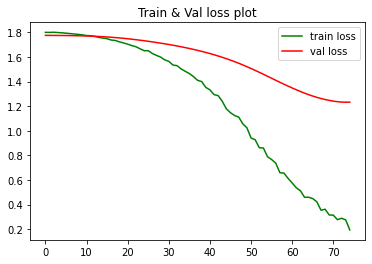

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(training_loss)), training_loss, color='green', label='train loss')
plt.plot(range(len(validation_loss)), validation_loss, color='red', label='val loss')
plt.legend()
plt.title("Train & Val loss plot")
plt.show()

**Evaluation**

In [24]:
# Let us evaluate our model using accuracy of its predictions. 
test_acc = None
mlp_model.eval()
with torch.no_grad():
    train_acc = evaluate_accuracy(mlp_model, data, data.train_mask)
    val_acc = evaluate_accuracy(mlp_model, data, data.val_mask)
    test_acc = evaluate_accuracy(mlp_model, data, data.test_mask)

print(f'Accuracy: Train {train_acc:.4f}, Val {val_acc:.4f}, Test {test_acc:.4f}')
print(f"Sanity check for the test: {test_acc > 0.55}") 

Accuracy: Train 1.0000, Val 0.5760, Test 0.5810
Sanity check for the test: True


Great, the model is able to learn something as we get at least 50% test accuracy! (much more than the random predictions). So, using node features help in generalization. Can we do better?

## Section 1.3 GCN for node classification [0.9 points]

The dataset has more information. In particular, we have the graph structure that relates a pair of nodes. Note that this is a semi-supervised setting so the nodes in the evaluation and test phase are also available during training. How to exploit the graph to learn the correlated probabilites of these nodes? 

**GCN Model Definition** [0.5 points]

Implement a 2 layer GCN using methods from Pytorch Geometric.





In [25]:
import torch.nn as nn
import torch.nn.functional as F

# Note: You will be using the GCNConv to implement a graph convolution layer
from torch_geometric.nn import GCNConv 

# Implement a GCN model with 2 GCNConv layers with ReLU non-linearity and dropout
class GCN(NCModel):
    def __init__(self, dataset, hidden_channels, dropout_probability):
        super(GCN, self).__init__(dataset)
        self.dataset = dataset
        self.conv1 = None
        self.conv2 = None
        self.dropout_p = dropout_probability

        # Implement a GCN model with 2 GCNConv layers with ReLU non-linearity and dropout
        # Step 1: Define the first convolutional layer (self.conv1) with input as the node features and output = hidden dimension size
        # Step 2: Define the second convolution layer (self.conv2) with input as hidden dimension size and output would be number of classes in the dataset
        
        ### write your code below [0.3 points] ##
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
        
        #########################################

    def forward(self, data):
        out = None

        # Step 1: Using the node features and the edge_index, compute intermediate representation via the first GCNConv layer
        # Step 2: Apply the ReLU non-linearity on the output of self.conv1
        # Step 3: Apply dropout
        # Step 4: Pass the output of step 3 through the second convolutional layer to get output logits
        # Step 5: Convert the logits to log probabilities using log_softmax and return them.

        ### write your code below [0.6 points] ##

        # step1
        data = dataset[0].to(device)
        features = data.x
        labels = data.y

        # step2
        features = self.conv1(features, data.edge_index)
        features = features.relu()

        # step3
        features = F.dropout(features, p=self.dropout_p, training=self.training)

        # step4
        features = self.conv2(features, data.edge_index)
        out = F.log_softmax(features, dim=1)
        

        #########################################

        return out

In [26]:
# Hyperparameters of the model. DO NOT CHANGE.
hidden_channels = 16
dropout_probability = 0.2

gcn_model = GCN(dataset, hidden_channels=hidden_channels, dropout_probability=dropout_probability).to(device)
print(gcn_model)


GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)


**Training Loop**

In [27]:
# Let us train this model.
torch.manual_seed(42)

# Hyperparameters of the model. DO NOT CHANGE.
num_epochs = 300 # Number of epochs
lr = 0.001 # learning rate, also called step size sometimes
wd = 1e-4 # Weight decay, regularization parameter (ensures that we don't overfit to the training data)

optimizer = optimizer_fn (gcn_model, lr, wd)

training_loss = []
validation_loss = []
for epoch in range(1, num_epochs+1):
    train_loss = train (gcn_model, data, criterion, optimizer)
    val_loss = validate (gcn_model, data, criterion)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    # Print loss values every 10 epochs
    if epoch%10 == 0:
      print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')

Epoch: 010, Training Loss: 1.7986 Validation Loss: 1.7965
Epoch: 020, Training Loss: 1.7824 Validation Loss: 1.7930
Epoch: 030, Training Loss: 1.7711 Validation Loss: 1.7876
Epoch: 040, Training Loss: 1.7569 Validation Loss: 1.7802
Epoch: 050, Training Loss: 1.7375 Validation Loss: 1.7705
Epoch: 060, Training Loss: 1.7099 Validation Loss: 1.7575
Epoch: 070, Training Loss: 1.6766 Validation Loss: 1.7402
Epoch: 080, Training Loss: 1.6416 Validation Loss: 1.7177
Epoch: 090, Training Loss: 1.5840 Validation Loss: 1.6893
Epoch: 100, Training Loss: 1.5388 Validation Loss: 1.6542
Epoch: 110, Training Loss: 1.4586 Validation Loss: 1.6112
Epoch: 120, Training Loss: 1.4006 Validation Loss: 1.5607
Epoch: 130, Training Loss: 1.2961 Validation Loss: 1.5036
Epoch: 140, Training Loss: 1.2139 Validation Loss: 1.4409
Epoch: 150, Training Loss: 1.1071 Validation Loss: 1.3747
Epoch: 160, Training Loss: 1.0186 Validation Loss: 1.3068
Epoch: 170, Training Loss: 0.9104 Validation Loss: 1.2399
Epoch: 180, Tr

**Plotting the loss curves**

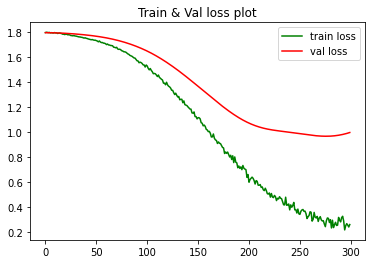

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(training_loss)), training_loss, color='green', label='train loss')
plt.plot(range(len(validation_loss)), validation_loss, color='red', label='val loss')
plt.legend()
plt.title("Train & Val loss plot")
plt.show()

**Evaluation**

In [29]:
# Let us evaluate our model using accuracy of its predictions. 
test_acc = None
gcn_model.eval()
with torch.no_grad():
    train_acc = evaluate_accuracy(gcn_model, data, data.train_mask)
    val_acc = evaluate_accuracy(gcn_model, data, data.val_mask)
    test_acc = evaluate_accuracy(gcn_model, data, data.test_mask)

print(f'Accuracy: Train {train_acc:.4f}, Val {val_acc:.4f}, Test {test_acc:.4f}')
print(f"Sanity check for the test: {test_acc > 0.70}") 

Accuracy: Train 0.9167, Val 0.7080, Test 0.7030
Sanity check for the test: True


## Section 1.4 Questions [0.2 points]

Q. Why does the MLP outperform the memorization/random model? [0.1 points]

> MLPs outperform the memorization/random model because they attempt to learn the structure of the graph (i.e. relationships between the nodes) using a node's features as well as its' neighboring nodes features. Doing this repeatedly with the two hidden linear layers allows the model to learn and extract more information, improving its ability to make predictions.

Q. Why does GCN outperform the MLP model? [0.1 points]

> GCNs take learning a step further -- instead of two linear layers, there are two convolution operations performed on the node features. This allows the GCN model to capture non-linear relationships between the nodes, ultimately learning more about the graph structure than the MLP.


# Section 2: Link Prediction [4.4 points]

Link Prediction predicts whether a link exists between a pair of nodes. Note that we don't need explicit labels to train for this task. This is because the input graph can be used to create labels for existing (positive) and non-existing (negative) links. We call this a self-supervised learning paradigm.

Link Prediction is an extremely useful task for two reasons -- 
1. It allows us to learn node (and link) representations/embeddings of the graph without any explicit supervision. 
2. Recommendation as an application can be modeled as a link prediction task. 

We will use the Citeseer dataset as above. 

In [30]:
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

## Section 2.1: Data creation [1.2 points]

`data.edge_index` stores the array of links in the graph. Let us split this into train, validation, and test sets of links and also find corresponding negative samples. We will use $60\%$ of the links for training, $10\%$ for validation, and $30\%$ for the test.

It is worthwhile to note here the structure of `data.edge_index`. The directed links (source, destination) are stored as a 2-D array with the first row storing the source nodes and the second row storing the corresponding destination nodes. `data.edge_index` does not store links in any arbitrary order. Instead, the links are ordered in increasing order of the source node with the link with the smaller destination node id appearing first if two links have the same source node. 

In [31]:
# Check the structure of edge_index
data.edge_index

tensor([[   0,    1,    1,  ..., 3324, 3325, 3326],
        [ 628,  158,  486,  ..., 2820, 1643,   33]], device='cuda:0')

Why would we want to order in this manner? Give at least one advantage. [0.1 points]

> Answer (write answer in this cell)

Since the edge_index is ordered, picking the first $60\%$ of the links for training would not be ideal. Hence, let us pick a random order first and then split the links into training, validation, and test. 

**Creating train/val/test split**

In [32]:
torch.manual_seed(42)
train_p, val_p, test_p = 0.6, 0.1, 0.3
# Step 1: Find a random permutation order of the links using torch.randperm
num_edges = data.edge_index.shape[1]
# rand_perm = torch.randperm(n=num_edges)
t = data.edge_index
edges_rand = t[:, torch.randperm(t.shape[1])]

# Step 2: Assign the first 60% (rounded down) of the links as the training set (data.train_mask), next 10% (rounded down) as the validation (data.val_mask), 
#         and the remaining as the test (data.test_mask). 
data.train_mask = edges_rand[0:2, 0:int(num_edges*.6)]
data.val_mask = edges_rand[0:2, range(int(num_edges*.6), int(num_edges*.7))]
data.test_mask = edges_rand[0:2, range(int(num_edges*.7), num_edges)]

# Step 3: Create new variables data.train_y, data.val_y, data.test_y storing all ones vector corresponding to the number of links in the corresponding set.
#         Make sure to put them on the memory of the `device` (default will be cpu but we want everything to be on GPU). 
## write your code below [0.5 points] ## 
data.train_y = torch.ones(data.train_mask.shape[1], dtype=torch.bool).to(device)
data.val_y = torch.ones(data.val_mask.shape[1], dtype=torch.bool).to(device)
data.test_y = torch.ones(data.test_mask.shape[1], dtype=torch.bool).to(device)
#########################################

In [33]:
print ((data.train_mask.shape[1] == data.train_y.shape[0]) and (data.train_y.shape[0] == 5462))
print ((data.val_mask.shape[1] == data.val_y.shape[0]) and (data.val_y.shape[0] == 910))
print ((data.test_mask.shape[1] == data.test_y.shape[0]) and (data.test_y.shape[0] == 2732))


True
True
True


Next, let us sample some negative links so that we can train. 

In [34]:
import random
torch.manual_seed(42)
random.seed(42)
negative_sampling_rate = 1

# Step 1: Use torch_geometric.utils.negative_sampling to obtain `negative_sampling_rate` number of negative samples for each positive link in `data.edge_index`.
#         Carefully read the documentation and check which arguments you would need to pass and how. 
nsr = torch_geometric.utils.negative_sampling(edge_index=data.edge_index, num_nodes=data.x.shape[0], num_neg_samples = data.edge_index.shape[1])

# Step 2: Append the first 60% (roudned down) of the non-existing links to the training set (data.train_mask), next 10% (rounded down) to the validation (data.val_mask), 
#         and the remaining to the test (data.test_mask). Use torch.cat with the correct dimension.
data.train_mask = torch.cat((data.train_mask, nsr[0:2, 0:int(num_edges*.6)]), 1)
data.val_mask = torch.cat((data.val_mask, nsr[0:2, range(int(num_edges*.6), int(num_edges*.7))]), 1)
data.test_mask = torch.cat((data.test_mask, nsr[0:2, range(int(num_edges*.7), num_edges)]), 1)

# Step 3: Append an all zeros vector to data.train_y, data.val_y, data.test_y corresponding to the number of links newly added to the corresponding set.
#         Make sure to match the `device` of the tensor. Use torch.cat with the correct dimension.
## write your code below [0.6 points] ## 
train_new = torch.zeros(data.train_mask.shape[1] - int(num_edges*.6), device=device, dtype=torch.bool)
val_new = torch.zeros(data.val_mask.shape[1] - int(num_edges*.1), device=device, dtype=torch.bool)
test_new = torch.zeros(data.test_mask.shape[1] - int(num_edges*.3) -1, device=device, dtype=torch.bool)

data.train_y = torch.cat((data.train_y, train_new), 0).to(device)
data.val_y = torch.cat((data.val_y, val_new), 0).to(device)
data.test_y = torch.cat((data.test_y, test_new), 0).to(device)

#########################################

In [35]:
num_edges = data.edge_index.shape[1]
print ((data.train_mask.shape[1] == data.train_y.shape[0]) and (data.train_y.shape[0] == int(train_p*num_edges)*(negative_sampling_rate+1)))
print ((data.val_mask.shape[1] == data.val_y.shape[0]) and (data.val_y.shape[0] == int(val_p*num_edges)*(negative_sampling_rate+1)))
print ((data.test_mask.shape[1] == data.test_y.shape[0]) and (data.test_y.shape[0] == (num_edges - int((train_p + val_p)*num_edges))*(negative_sampling_rate+1)))

True
True
True


In [36]:
data.train_y.shape[0], data.val_y.shape[0], data.test_y.shape[0]

(10924, 1820, 5464)

## Section 2.2: General Link Prediction Model [2.0 points]

What would be the corresponding memorization model if one were to make? We cannot learn a probability weight for each link (since it would be extremely memory inefficient, would give a memory overflow in fact). So, one simple model would be to learn an embedding for each node and then, pass a concatenation of the embeddings of two nodes through an MLP decoder to find the probability of a link between these two nodes. 

### Model Definition [0.9 points]

In [37]:
from numpy import log10
import torch
import torch.nn.functional as F
from torch.nn import Linear

class LPModel (torch.nn.Module):
    def __init__(self, dataset, hidden_channels=16):
        super().__init__()
        self.emb = torch.nn.Parameter(torch.rand(dataset[0].num_nodes, hidden_channels).to(device))
        self.dec = None
        # Define the decoder (self.dec) as a single Linear layer that transforms an input of dimension 2*hidden_channels to an output of dimension 1. 
        ## write your code below [0.1 points] ##
        self.dec =  Linear(2*hidden_channels, 1)
        #########################################
    
    def forward (self, data):
        # Returns the embeddings of all nodes
        return self.emb

    def predict_proba (self, data, node_pairs):
        prob = None
        # Predict probabilities of link existence between the node_pairs (of dimension (num_node_pairs, 2))
        ## write your code below [0.6 points] ##
        
        # Step 1: Call the forward function to obtain the embeddings from the data.
        emb = self.forward(data)
        # Step 2: Obtain the node embeddings for source and destination nodes from the node_pairs array and concatenate them together. 
        all_embs = []
        logits = torch.zeros(node_pairs.shape[1])
        ## node_pairs.shape = (2, 10924)
        for j in range(node_pairs.shape[1]):
          source_emb = emb[node_pairs[0, j]]
          dest_emb = emb[node_pairs[1, j]]
          node_emb_sd = torch.stack((source_emb, dest_emb), 1)
          all_embs.append(node_emb_sd)

          # Step 3: Pass the concatenated embeddings (of size 2*hidden_channels) through the decoder to obtain the logits for each node pair in node_pairs. 
          log = self.dec(torch.reshape(node_emb_sd, (1,2*hidden_channels)))
          logits[j] = log

        # Step 4: Use sigmoid activation torch.sigmoid() to obtain the probabilities between 0 and 1.
        logits = logits.sigmoid()

        # Step 5: Squeeze the values so that the output is (num_node_pairs,)
        prob = torch.squeeze(logits).to(device)
        #########################################
        return prob

    def predict (self, data, node_pairs):
        pred = None
        # Step 1: Predict the probabilities of link existence between the node_pairs using the predict_proba method
        # Step 2: Obtain the predicted label as 1 if probability is greater than 0.5 and 0 otherwise.
        ### write your code below [0.2 points] ##
        prob = self.predict_proba(data, node_pairs)
        pred = [1.0 if i > 0.1 else 0 for i in prob]
        
        #########################################
        return pred

In [38]:
mem_model = LPModel (dataset).to(device)

### Training [1.1 points]

**Setup** [0.1 points]

In [39]:
criterion = None

### write your code below [0.1 points] ##
# Initialize loss criterion as the binary cross entropy loss function
criterion = torch.nn.BCELoss()
#########################################

**Backpropagation** [0.5 points]

In [40]:
# Gradient Descent training algorithm. We will use this function for MLP and GCN too.
def train_lp (model, data, criterion, optimizer, neg_weight=1):
    model.train()
    train_pos_loss, train_neg_loss = None, None
    
    # Step 1: Extract the link existence probability of only the positive (i.e., existing) training links using predict_proba 
    #          (you can use data.train_mask to obtain the positive training links and data.train_y to filter). 
    # Step 2: Compute the criterion loss between predicted probabilities and the actual labels of the positive 
    #           training links and store it in train_pos_loss
    # Step 3: Similarly, extract the link existence probability of only the negative (i.e., non-existing) training links using predict_proba 
    #          (you can use data.train_mask to obtain the negative training links and data.train_y to filter). 
    # Step 4: Compute the criterion loss between predicted probabilities and the actual labels of the negative 
    #           training links and store it in train_neg_loss
    # Step 5: Compute the gradients of the training loss (train_pos_loss + neg_weight*train_neg_loss) with respect to each parameter using the backward() call.
    # Step 6: Update the model parameters using the optimizer step() call.
    # Make sure to return a detached cpu tensor
    ### write your code below [0.5 points] ##
    
    lep_pos_train = model.predict_proba(data, data.train_mask)[data.train_y]
    train_pos_loss = criterion(lep_pos_train, torch.ones(lep_pos_train.shape, device=device))
    grad_pos_loss = train_pos_loss.backward()

    lep_neg_train = model.predict_proba(data, data.train_mask)[~data.train_y]
    train_neg_loss = criterion(lep_neg_train, torch.zeros(lep_neg_train.shape, device=device))
    grad_neg_loss = train_neg_loss.backward()

    optimizer.step()

    #########################################
    return train_pos_loss.detach().cpu(), train_neg_loss.detach().cpu()

**Validation** [0.3 points]

In [41]:
# Validate the model on a held-out validataion dataset. We will reuse this function for GCN too.
def validate_lp (model, data, criterion, neg_weight=1):
    model.eval()
    val_loss = None
    with torch.no_grad():
        # Step 1: Extract the link existence probability of only the positive (i.e., existing) links in the validation set using predict_proba 
        #          (you can use data.train_mask to obtain the positive training links and data.train_y to filter).
        # Step 2: Compute the criterion loss between predicted probabilities and the actual labels of the positive links in the validation set
        #          and store it in val_pos_loss
        # Step 3: Extract the link existence probability of only the negative (i.e., existing) links in the validation set using predict_proba 
        #          (you can use data.train_mask to obtain the negative training links and data.train_y to filter).
        # Step 4: Compute the criterion loss between predicted probabilities and the actual labels of the negative links in the validation set
        #          and store it in val_neg_loss
        # Step 5: Find val_loss as val_pos_loss + neg_weight * val_neg_loss.
        # Make sure to return a CPU tensor.
        ### write your code below [0.3 points] ##

        lep_pos_val = model.predict_proba(data, data.val_mask)[data.val_y]
        val_pos_loss = criterion(lep_pos_val, torch.ones(lep_pos_val.shape, device=device))

        lep_neg_val = model.predict_proba(data, data.val_mask)[~data.val_y]
        val_neg_loss = criterion(lep_neg_val, torch.zeros(lep_neg_val.shape, device=device))

        val_loss = val_pos_loss + neg_weight * val_neg_loss
        
        #########################################
    return val_loss.cpu()

**Training loop**

In [42]:
# Let us train this model.
torch.manual_seed(42)

# Hyperparameters of the model. DO NOT CHANGE.
num_epochs = 200 # Number of epochs
lr = 0.0001 # learning rate, also called step size sometimes
wd = 1e-4 # Weight decay, regularization parameter (ensures that we don't overfit to the training data)

optimizer = optimizer_fn (mem_model, lr, wd)

training_loss = []
validation_loss = []
#data = data.to('cuda:0', non_blocking=True)
for epoch in range(1, num_epochs+1):
    train_loss = train_lp (mem_model, data, criterion, optimizer)
    val_loss = validate_lp (mem_model, data, criterion)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    train_loss = sum(train_loss)
    # Print loss values every 10 epochs
    if epoch%10 == 0:
      print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')

Epoch: 010, Training Loss: 1.4375 Validation Loss: 1.4365
Epoch: 020, Training Loss: 1.4319 Validation Loss: 1.4304
Epoch: 030, Training Loss: 1.4234 Validation Loss: 1.4216
Epoch: 040, Training Loss: 1.4136 Validation Loss: 1.4114
Epoch: 050, Training Loss: 1.4041 Validation Loss: 1.4018
Epoch: 060, Training Loss: 1.3967 Validation Loss: 1.3943
Epoch: 070, Training Loss: 1.3926 Validation Loss: 1.3902
Epoch: 080, Training Loss: 1.3926 Validation Loss: 1.3903
Epoch: 090, Training Loss: 1.3966 Validation Loss: 1.3945
Epoch: 100, Training Loss: 1.4040 Validation Loss: 1.4020
Epoch: 110, Training Loss: 1.4134 Validation Loss: 1.4113
Epoch: 120, Training Loss: 1.4230 Validation Loss: 1.4208
Epoch: 130, Training Loss: 1.4313 Validation Loss: 1.4287
Epoch: 140, Training Loss: 1.4366 Validation Loss: 1.4337
Epoch: 150, Training Loss: 1.4382 Validation Loss: 1.4349
Epoch: 160, Training Loss: 1.4356 Validation Loss: 1.4320
Epoch: 170, Training Loss: 1.4294 Validation Loss: 1.4256
Epoch: 180, Tr

**Plotting the loss curves**

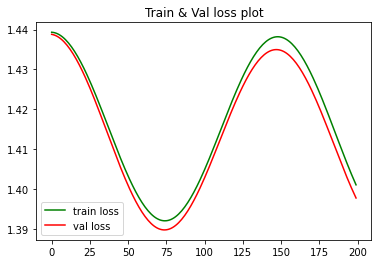

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(training_loss)), [x[0] + x[1] for x in training_loss], color='green', label='train loss')
plt.plot(range(len(validation_loss)), validation_loss, color='red', label='val loss')
plt.legend()
plt.title("Train & Val loss plot")
plt.show()

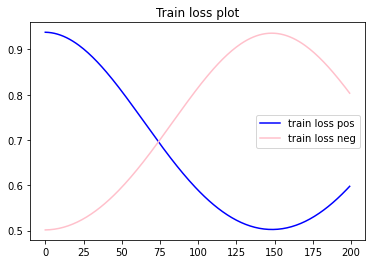

In [44]:
plt.plot(range(len(training_loss)), [x[0] for x in training_loss], color='blue', label='train loss pos')
plt.plot(range(len(training_loss)), [x[1] for x in training_loss], color='pink', label='train loss neg')
plt.legend()
plt.title("Train loss plot")
plt.show()

**Evaluation** [0.2 points]

We will evaluate the model using the AUC metric. For that let us first create a function to obtain the AUC values. 

In [45]:
from sklearn.metrics import roc_auc_score
def evaluate_auc (model, data, eval_nodepairs, eval_labels):
    auc = None
    # Step 1: Obtain link existence probabilities for the node pairs in eval_nodepairs. 
    # Step 2: Calculate the roc_auc_score using predicted probabilities and actual labels. 
    # Step 3: Return the calculated roc_auc_score.
    # Make sure to convert to CPU tensors. 
    ## write your code below (0.2 points) ##
    
    lep =  model.predict_proba(data, eval_nodepairs)
    auc = roc_auc_score(eval_labels.detach().cpu().numpy(), lep.detach().cpu().numpy())

    #########################################
    return auc

In [46]:
mem_model.eval()
with torch.no_grad():
    train_auc = evaluate_auc(mem_model, data, data.train_mask, data.train_y)
    val_auc = evaluate_auc(mem_model, data, data.val_mask, data.val_y)
    test_auc = evaluate_auc(mem_model, data, data.test_mask, data.test_y)
    print (f'Train AUC: {train_auc:0.4f}, Val AUC: {val_auc:0.4f}, Test AUC: {test_auc:0.4f}')
    print (f'Sanity check for Test AUC: {abs(test_auc - 0.5) <= 5e-2}')

Train AUC: 0.4999, Val AUC: 0.5085, Test AUC: 0.4822
Sanity check for Test AUC: True


## Section 2.3: MLP for link prediction [0.3 points]

Let us now use the input data a little more carefully. In particular, let us make use of the input node attributes to learn the node labels using a two layer perceptron.

**Model Definition** [0.3 points]

Implement a two layer MLP with hidden dimension size as 16 and train the model on the dataset. We want to use ReLU activation and dropout with p = 0.2

In [47]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

# This is similar to the above MLP definition.
class MLP (LPModel):
    def __init__(self, dataset, hidden_channels=32, dropout_probability=0.5):
        super(MLP, self).__init__(dataset, hidden_channels)
        """
        Use the constructor to initialize the layers of the network. In this case 2 linear layers
        Read more about Linear layers in PyTorch here: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear
        """

        self.lin1 = None 
        self.lin2 = None
        self.dropout_p = dropout_probability

        # Step 1: The first linear layer (self.lin1) should convert the input features to hidden dimension size which will then be fed into self.lin2
        # Step 2: The second linear layer (self.lin2) should convert the output of self.lin1 to the hidden dimension to obtain the embedding

        ### write your code below [0.1 points] ##
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        #########################################


    def forward(self, data):
        # overriding the random model
        out = None
        # Step 1. Extract node features and target labels from data
        # Step 2. Call the first linear layer (self.lin1)
        # Step 3. The output of the linear layer should be passed through a ReLU non-linearity
        # Step 4. Apply dropout with dropout probability p as self.dropout_p 
        # Step 5: Apply the second linear layer to get the embeddings
        ### write your code below [0.2 points] ##

        data = dataset[0].to(device)
        features = data.x
        labels = data.y

        features = self.lin1(features)
        features = features.relu()
        features = F.dropout(features, p=self.dropout_p, training=self.training)

        out = self.lin2(features)

        #########################################
        return out

In [48]:
hidden_channels=16
dropout_probability=0.2

mlp_model = MLP(dataset, hidden_channels=hidden_channels, dropout_probability=dropout_probability).to(device)

## Print the model and double check that you have implemented the correct 2-layer MLP
print(mlp_model)

MLP(
  (dec): Linear(in_features=32, out_features=1, bias=True)
  (lin1): Linear(in_features=3703, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
)


**Training loop**

In [49]:
# Let us train this model.
torch.manual_seed(42)

# Hyperparameters of the model. DO NOT CHANGE.
num_epochs = 200 # Number of epochs
lr = 0.001 # learning rate, also called step size sometimes
wd = 1e-4 # Weight decay, regularization parameter (ensures that we don't overfit to the training data)

optimizer = optimizer_fn (mlp_model, lr, wd)

training_loss = []
validation_loss = []

for epoch in range(1, num_epochs+1):
    train_loss = train_lp (mlp_model, data, criterion, optimizer)
    val_loss = validate_lp (mlp_model, data, criterion)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    train_loss = sum(train_loss)
    # Print loss values every 10 epochs
    if epoch%10 == 0:
      print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')

Epoch: 010, Training Loss: 1.3870 Validation Loss: 1.3869
Epoch: 020, Training Loss: 1.3869 Validation Loss: 1.3867
Epoch: 030, Training Loss: 1.3864 Validation Loss: 1.3864
Epoch: 040, Training Loss: 1.3863 Validation Loss: 1.3862
Epoch: 050, Training Loss: 1.3859 Validation Loss: 1.3860
Epoch: 060, Training Loss: 1.3858 Validation Loss: 1.3859
Epoch: 070, Training Loss: 1.3857 Validation Loss: 1.3859
Epoch: 080, Training Loss: 1.3857 Validation Loss: 1.3859
Epoch: 090, Training Loss: 1.3852 Validation Loss: 1.3858
Epoch: 100, Training Loss: 1.3852 Validation Loss: 1.3855
Epoch: 110, Training Loss: 1.3845 Validation Loss: 1.3851
Epoch: 120, Training Loss: 1.3834 Validation Loss: 1.3845
Epoch: 130, Training Loss: 1.3825 Validation Loss: 1.3838
Epoch: 140, Training Loss: 1.3819 Validation Loss: 1.3831
Epoch: 150, Training Loss: 1.3810 Validation Loss: 1.3825
Epoch: 160, Training Loss: 1.3795 Validation Loss: 1.3818
Epoch: 170, Training Loss: 1.3786 Validation Loss: 1.3810
Epoch: 180, Tr

**Plotting the loss curves**

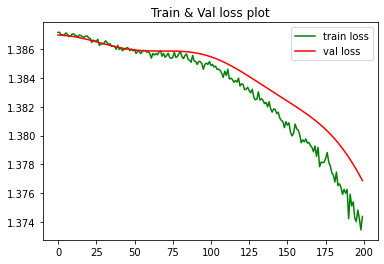

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(training_loss)), [x[0] + x[1] for x in training_loss], color='green', label='train loss')
plt.plot(range(len(validation_loss)), validation_loss, color='red', label='val loss')
plt.legend()
plt.title("Train & Val loss plot")
plt.show()

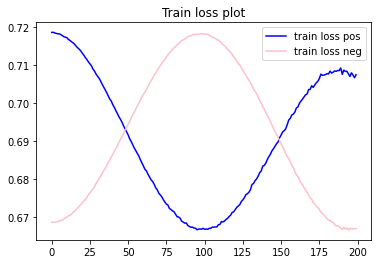

In [51]:

plt.plot(range(len(training_loss)), [x[0] for x in training_loss], color='blue', label='train loss pos')
plt.plot(range(len(training_loss)), [x[1] for x in training_loss], color='pink', label='train loss neg')
plt.legend()
plt.title("Train loss plot")
plt.show()

**Evaluation**

In [52]:
mlp_model.eval()
with torch.no_grad():
    train_auc = evaluate_auc(mlp_model, data, data.train_mask, data.train_y)
    val_auc = evaluate_auc(mlp_model, data, data.val_mask, data.val_y)
    test_auc = evaluate_auc(mlp_model, data, data.test_mask, data.test_y)
    print (f'Train AUC: {train_auc:0.4f}, Val AUC: {val_auc:0.4f}, Test AUC: {test_auc:0.4f}')
    print (f'Sanity check for Test AUC: {test_auc >= 0.55}')

Train AUC: 0.6274, Val AUC: 0.5721, Test AUC: 0.5723
Sanity check for Test AUC: True


## Section 2.4: GCN for link prediction [0.3 points]

The dataset has more information. In particular, we have the graph structure that relates a pair of nodes. Note that this is a semi-supervised setting so the nodes in the evaluation and test phase are also available during training. How to exploit the graph to learn the correlated probabilites of these nodes? 

**Model Definition**

Implement a 2 layer GCN using methods from Pytorch Geometric.





In [53]:
from prompt_toolkit import output
import torch.nn as nn
import torch.nn.functional as F

# Note: You will be using the GCNConv to implement a graph convolution layer
from torch_geometric.nn import GCNConv 

# Implement a GCN model with 2 GCNConv layers with ReLU non-linearity and dropout

# This is similar to the above GCN definition.
class GCN(LPModel):
    def __init__(self, dataset, hidden_channels, dropout_probability):
        super(GCN, self).__init__(dataset, hidden_channels)
        self.dataset = dataset
        self.conv1 = None
        self.conv2 = None
        self.dropout_p = dropout_probability

        # Implement a GCN model with 2 GCNConv layers with ReLU non-linearity and dropout
        # Step 1: Define the first convolutional layer (self.conv1) with input as the node features and output = hidden dimension size
        # Step 2: Define the second convolution layer (self.conv2) with input as hidden dimension size and output would be number of classes in the dataset
        
        ### write your code below [0.1 points] ##
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        #########################################

    def forward(self, data):
        out = None

        # Step 1: Using the node features and the edge_index, compute intermediate representation via the first GCNConv layer
        # Step 2: Apply the ReLU non-linearity on the output of self.conv1
        # Step 3: Apply dropout
        # Step 4: Pass the output of step 3 through the second convolutional layer to get output embeddings 

        ### write your code below [0.2 points] ##

        # step1
        data = dataset[0].to(device)
        features = data.x
        labels = data.y

        # step2
        features = self.conv1(features, data.edge_index)
        features = features.relu()

        # step3
        features = F.dropout(features, p=self.dropout_p, training=self.training)

        # step4
        out = self.conv2(features, data.edge_index)

        #########################################

        return out

In [54]:
# Hyperparameters of the model. DO NOT CHANGE.
hidden_channels = 16
dropout_probability = 0.2

gcn_model = GCN(dataset, hidden_channels=hidden_channels, dropout_probability=dropout_probability).to(device)
print(gcn_model)


GCN(
  (dec): Linear(in_features=32, out_features=1, bias=True)
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 16)
)


**Training loop**

In [55]:
# Let us train this model.
torch.manual_seed(42)

# Hyperparameters of the model. DO NOT CHANGE.
num_epochs = 200 # Number of epochs
lr = 0.001 # learning rate, also called step size sometimes
wd = 1e-4 # Weight decay, regularization parameter (ensures that we don't overfit to the training data)

optimizer = optimizer_fn (gcn_model, lr, wd)

training_loss = []
validation_loss = []

for epoch in range(1, num_epochs+1):
    train_loss = train_lp (gcn_model, data, criterion, optimizer)
    val_loss = validate_lp (gcn_model, data, criterion)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    train_loss = sum(train_loss)
    # Print loss values every 10 epochs
    if epoch%10 == 0:
      print(f'Epoch: {epoch:03d}, Training Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}')

Epoch: 010, Training Loss: 1.3860 Validation Loss: 1.3853
Epoch: 020, Training Loss: 1.3846 Validation Loss: 1.3845
Epoch: 030, Training Loss: 1.3830 Validation Loss: 1.3832
Epoch: 040, Training Loss: 1.3809 Validation Loss: 1.3814
Epoch: 050, Training Loss: 1.3778 Validation Loss: 1.3793
Epoch: 060, Training Loss: 1.3762 Validation Loss: 1.3769
Epoch: 070, Training Loss: 1.3714 Validation Loss: 1.3743
Epoch: 080, Training Loss: 1.3695 Validation Loss: 1.3715
Epoch: 090, Training Loss: 1.3648 Validation Loss: 1.3682
Epoch: 100, Training Loss: 1.3626 Validation Loss: 1.3642
Epoch: 110, Training Loss: 1.3547 Validation Loss: 1.3591
Epoch: 120, Training Loss: 1.3487 Validation Loss: 1.3523
Epoch: 130, Training Loss: 1.3350 Validation Loss: 1.3439
Epoch: 140, Training Loss: 1.3257 Validation Loss: 1.3341
Epoch: 150, Training Loss: 1.3113 Validation Loss: 1.3235
Epoch: 160, Training Loss: 1.2946 Validation Loss: 1.3130
Epoch: 170, Training Loss: 1.2931 Validation Loss: 1.3030
Epoch: 180, Tr

**Plotting the loss curves**

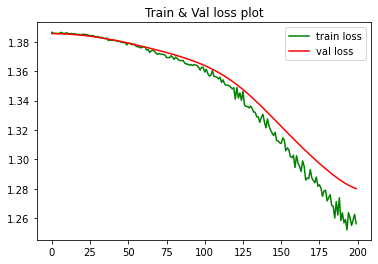

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(training_loss)), [x[0] + x[1] for x in training_loss], color='green', label='train loss')
plt.plot(range(len(validation_loss)), validation_loss, color='red', label='val loss')
plt.legend()
plt.title("Train & Val loss plot")
plt.show()

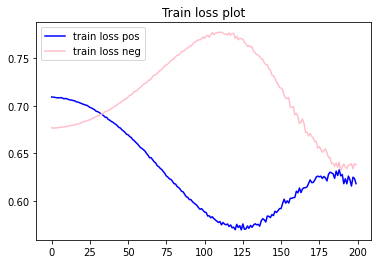

In [57]:
plt.plot(range(len(training_loss)), [x[0] for x in training_loss], color='blue', label='train loss pos')
plt.plot(range(len(training_loss)), [x[1] for x in training_loss], color='pink', label='train loss neg')
plt.legend()
plt.title("Train loss plot")
plt.show()

**Evaluation**

In [58]:
gcn_model.eval()
with torch.no_grad():
    train_auc = evaluate_auc(gcn_model, data, data.train_mask, data.train_y)
    val_auc = evaluate_auc(gcn_model, data, data.val_mask, data.val_y)
    test_auc = evaluate_auc(gcn_model, data, data.test_mask, data.test_y)
    print (f'Train AUC: {train_auc:0.4f}, Val AUC: {val_auc:0.4f}, Test AUC: {test_auc:0.4f}')
    print (f'Sanity check for Test AUC: {test_auc >= 0.65}')

Train AUC: 0.6922, Val AUC: 0.6460, Test AUC: 0.6570
Sanity check for Test AUC: True


## Section 2.5: Questions [0.6 points]

Q. Why does MLP not improve the performance significantly over the memorization model in this case? [0.1 points]

> One reason why MLP might not improve performance significantly is because the graph making link predictions is more related to the structure of the graph rather than the characteristics of the nodes themselves. MLP uses linear layers to understand some of the graph structure, but not enough to make a significant difference when predicting links.

Q. Why does GCN perform so much better than MLP for link prediction? [0.1 points]

> GCN improves link predictions significantly because the convolution layers allow for the model to capture nonlinear relationships between the nodes. This ability to understand graph structure better is more important when predicting links than classifying nodes, which is why a more complicated model works much better.

Q. Compare the shape of training and validation loss curves observed for node classification and link prediction? How are they different? What could be reason why you observe sinusoid-like loss in one versus the other? [0.2 points]

> For node classification, the training and validation loss curves generally decrease monotonically, whereas they have a sinusoid-like loss shape for link prediction. For node classification, we use a negative log-likelihood function, which produces a value of 0 to infinity, whereas the binary cross entropy function used for link prediction produces values between 0 and 1 -- this explains why the loss values fall between some range, instead of increasing or decreasing indefinitely. Additionally, it appears that there is no convergence in link prediction losses because the models are unable to fully capture the complexity and nonlinearity in in the graph, even if we use a GCN.

Q. What can you do in the training to improve the performance even more? Give at least 2 suggestions. [0.2 points]

> 1. Utilize MLPInit: Gaining inspiration from the guest speaker from LinkedIn, perhaps we can initialize the weights of the GNN training with a simple MLP. Instead of starting from scratch, we would have a better baseline/framework to train the graph, which might provide faster convergence and give us a loss graph that is not sinusoidal. On the datasets used in the paper, MLPInit improved accuracy significantly and decreased the time taken to train the GNN.

> 2. Tune the hyperparameters: There are several hyperparameters in MLP and GCN, including learning rate, weight decay, and dropout probability. Tuning these hyperparameters may improve performance significantly. For instance, dropout is a regularization method that essentially randomly "drops out" neurons to make sure some weights in the neural net are not outrageously high, aiming to prevent overfitting when training. We can improve this by testing different values for dropout proportion, or even try to implement other regularization techniques like Ridge or Lasso.